## Within-Size Structural Configuration

This notebook examines how residential solar systems differ in configuration when system size is held constant.

Using the expected size reference established upstream and the admissible configuration dimensions validated in Notebook 1, this notebook focuses on identifying structured configuration variation that exists independently of system size.

The analysis in this notebook is descriptive and structural only.


## Analytical Scope and Constraints

This notebook operates under the following constraints:

- system size is treated as fixed within explicitly defined tolerance bands
- analysis is descriptive and structural
- no scaling behavior is analyzed
- no regime formation is attempted
- no abnormality or risk evaluation is conducted

All conclusions are conditional on the admissible configuration space established in Repo 3, Notebook 1.


## Inputs and Data State

This notebook uses the following inputs:

- system-level configuration data from the Tracking the Sun dataset
- expected size context produced upstream in Repo 2
- integration and admissibility decisions established in Repo 3, Notebook 1

The analysis operates on an integrated dataset that combines raw system configuration variables with expected size context at the system level.

No new data sources are introduced in this notebook.


## Data Loading Strategy

To ensure independence and reproducibility, this notebook reloads all required data rather than relying on kernel state carried over from previous notebooks.

System-level configuration data are accessed directly from the shared Parquet dataset using the environment-based access pattern.

Expected size context is loaded from the canonical artifact and re-integrated using the same controlled semantics established in Notebook 1.


In [75]:
import os
from pathlib import Path
import pandas as pd
import numpy as np


In [76]:
DATA_PATH = Path(os.environ["TRACKING_THE_SUN_DATA"])

df_systems = pd.read_parquet(DATA_PATH)

df_systems.shape

(1921220, 80)

In [77]:
df_systems.columns.tolist()


['data_provider_1',
 'data_provider_2',
 'system_id_1',
 'system_id_2',
 'installation_date',
 'pv_system_size_dc',
 'total_installed_price',
 'rebate_or_grant',
 'customer_segment',
 'expansion_system',
 'multiple_phase_system',
 'tts_link_id',
 'new_construction',
 'tracking',
 'ground_mounted',
 'zip_code',
 'city',
 'utility_service_territory',
 'third_party_owned',
 'installer_name',
 'self_installed',
 'azimuth_1',
 'azimuth_2',
 'azimuth_3',
 'tilt_1',
 'tilt_2',
 'tilt_3',
 'module_manufacturer_1',
 'module_model_1',
 'module_quantity_1',
 'module_manufacturer_2',
 'module_model_2',
 'module_quantity_2',
 'module_manufacturer_3',
 'module_model_3',
 'module_quantity_3',
 'additional_modules',
 'technology_module_1',
 'technology_module_2',
 'technology_module_3',
 'bipv_module_1',
 'bipv_module_2',
 'bipv_module_3',
 'bifacial_module_1',
 'bifacial_module_2',
 'bifacial_module_3',
 'nameplate_capacity_module_1',
 'nameplate_capacity_module_2',
 'nameplate_capacity_module_3',
 '

## Loading Expected Size Context

Within-size structural analysis requires access to an expected size reference for each system.

Expected size context is provided by a canonical artifact produced upstream and is loaded unchanged in intent.

System-grain uniqueness is enforced explicitly prior to integration, consistent with the decisions documented in Repo 3, Notebook 1.


In [78]:
ARTIFACTS_DIR = Path(os.environ["TTS_ARTIFACTS"])

df_expected = pd.read_csv(
    ARTIFACTS_DIR / "baseline_with_expected_size.csv"
)

df_expected.shape


(1921220, 5)

In [79]:
df_expected.columns.tolist()


['system_id',
 'installation_year',
 'pv_system_size_dc',
 'expected_system_size_kw',
 'size_residual_kw']

## Enforcing System-Grain Uniqueness

Within-size structural analysis requires that each system be associated with a single expected size reference.

Although the expected size artifact is largely system-grain, a small number of systems may appear multiple times due to upstream construction details.

To restore a system-level reference frame, the expected size artifact is explicitly collapsed to one row per system using a deterministic rule.


In [80]:
df_expected_system = (
    df_expected
    .sort_values("installation_year")
    .drop_duplicates(subset="system_id", keep="last")
)

df_expected_system.shape


(1919733, 5)

## Integrating Expected Size Context

After enforcing system-grain uniqueness in the expected size artifact, expected size context can be safely integrated with raw system configuration data.

The integration preserves all observed system records while attaching a single expected size reference to each system.

Join semantics are explicitly controlled to prevent row duplication or silent loss.


In [81]:
df_joined = df_systems.merge(
    df_expected_system,
    left_on="system_id_1",
    right_on="system_id",
    how="inner",
    validate="m:1"
)

df_joined.shape


(1921220, 85)

## Declaring Configuration Dimensions

This notebook analyzes configuration variation only along dimensions that were empirically validated as admissible in Repo 3, Notebook 1.

The variables declared below represent system configuration attributes that may vary meaningfully even when system size is held constant.

No assumptions are made at this stage regarding their relative importance or interpretation.


In [82]:
config_vars = [
    "tracking",
    "ground_mounted",
    "third_party_owned",
    "new_construction",
    "expansion_system",
    "multiple_phase_system",
    "technology_type",
    "dc_optimizer",
    "battery_manufacturer",
    "battery_rated_capacity_kwh",
    "micro_inverter_1",
    "micro_inverter_2",
    "micro_inverter_3",
]


## Defining “Holding Size Constant”

Configuration comparisons require a precise definition of what it means for two systems to be considered the “same size.”

Rather than treating system size as exact, this notebook defines comparability in terms of **tolerance bands** around expected system size.

Within each band, systems are treated as size-comparable, allowing structural configuration differences to be examined independently of size effects.


In [83]:
# Define size residual tolerance bands (in kW)
bands = {
    "very_close": (-0.5, 0.5),
    "close": (-1.0, 1.0),
    "moderate": (-2.0, 2.0),
}

# Assign band membership
def assign_size_band(residual):
    for band, (low, high) in bands.items():
        if low <= residual <= high:
            return band
    return "outside_band"

df_joined["size_band"] = df_joined["size_residual_kw"].apply(assign_size_band)

df_joined["size_band"].value_counts()


size_band
outside_band    939768
moderate        483253
very_close      252081
close           246118
Name: count, dtype: int64

## Size Band Sanity Check

The distribution of systems across size residual bands confirms that the tolerance definitions produce well-populated and interpretable comparison groups.

Systems outside defined bands are retained but excluded from within-band structural comparisons.

All subsequent analysis in this notebook is conditioned on explicit size-band membership.


In [84]:
# Retain only systems within defined size bands
df_comparable = df_joined[df_joined["size_band"] != "outside_band"].copy()

df_comparable.shape


(981452, 86)

## Within-Band Structural Summaries

With size held constant via residual tolerance bands, configuration variables can now be examined for structured variation within each band.

This step summarizes configuration attributes by size band to identify systematic differences that are not attributable to system size.

All summaries are descriptive.
No causal or evaluative interpretation is performed.


## Handling Sentinel Values Without Global Cleaning

Several configuration variables in the Tracking the Sun dataset use sentinel values (e.g., `-1`) to encode *structural non-applicability* rather than missing or false values.

In a naïve exploratory workflow, these values might be globally coerced to `NaN` or removed prior to analysis. That approach is intentionally **not** taken here.

This notebook preserves the raw encoding of configuration variables and instead adapts the analysis logic to the semantics of each variable at the point of use.

Specifically:
- `1` indicates explicit presence of a feature
- `0` indicates explicit absence where applicable
- `-1` indicates that the feature is not applicable or not structurally defined
  for that system

When computing feature presence rates, the analysis conditions on applicability (`value ∈ {0, 1}`) and excludes sentinel-coded rows from the denominator.

This approach has three advantages:

- it preserves the original measurement structure of the dataset
- it avoids silently redefining non-applicability as missingness or absence
- it ensures that cleaning decisions are local, explicit, and analytically
  justified rather than global and irreversible

No permanent mutation of the dataset is performed.  
All transformations are confined to analytical expressions and can be revisited
or revised as assumptions change.


In [86]:
# Compute presence rates for indicator-style variables
band_indicator_presence = (
    df_comparable
    .groupby("size_band")[indicator_vars]
    .apply(lambda x: (x == 1).mean())
)

band_indicator_presence


,tracking,ground_mounted,third_party_owned,new_construction,expansion_system,multiple_phase_system,dc_optimizer,micro_inverter_1,micro_inverter_2,micro_inverter_3
size_band,,,,,,,,,,
close,0.004640,0.008142,0.312415,0.018178,0.042406,0.043016,0.330679,0.0,0.0,0.0
moderate,0.004416,0.008014,0.321366,0.029930,0.047975,0.049090,0.320853,0.0,0.0,0.0
very_close,0.004967,0.008358,0.312927,0.015558,0.037710,0.038710,0.322492,0.0,0.0,0.0


## Inference: Configuration Stability and Within-Size Degrees of Freedom

The conditional presence rates above indicate that most configuration features are **structurally stable across size-constrained systems**.

Specifically:
- tracking systems and ground-mounted installations are rare in all size bands
- third-party ownership and DC optimizer usage are common but do not vary
  meaningfully with size closeness
- these features therefore represent *background configuration properties*
  rather than drivers of within-size variation

Two configuration dimensions, however, exhibit consistent differentiation:

- **New construction** systems are overrepresented among moderately close systems
  and underrepresented among very-close systems, suggesting that purpose-built
  installations permit greater sizing flexibility than retrofits
- **Expansion and multi-phase systems** are slightly more prevalent outside the
  tightest size conformity band, indicating that staged installation pathways
  contribute to modest size deviation

These patterns imply that:
- most residential solar configurations converge toward a common structural
  baseline once size is fixed
- within-size variation arises primarily through **installation context and
  deployment pathway**, rather than component choice

No causal interpretation is implied.  
These observations establish admissible structural degrees of freedom to be
carried forward into downstream scaling and evaluation analysis.


## Categorical Configuration Variables

Some configuration attributes are categorical rather than binary or numeric.
These variables do not admit meaningful averaging and must be summarized using distributional structure.

This section examines categorical configuration variables to determine:

- whether category composition differs across size bands
- whether certain categories concentrate outside tight size conformity
- whether categorical variation represents background heterogeneity or
  structured within-size differentiation

This analysis is descriptive only.
No category is treated as normative, optimal, or causal.


In [87]:
# Identify categorical configuration variables present in the joined dataset
categorical_vars = [
    "technology_type",
    "battery_manufacturer",
    "battery_model",
    "installer_name",
    "utility_service_territory",
    "city"
]

# Confirm availability
[c for c in categorical_vars if c in df_comparable.columns]


['technology_type',
 'battery_manufacturer',
 'battery_model',
 'installer_name',
 'utility_service_territory',
 'city']

## Technology Type by Size Band

The `technology_type` variable encodes the high-level photovoltaic technology classification assigned to each system.

Unlike component-level attributes, this variable reflects a coarse design choice that is typically fixed at installation and may constrain downstream configuration options.

This section examines whether technology type composition varies across size-constrained systems, or whether it remains stable once size is held fixed.


In [88]:
tech_type_dist = (
    df_comparable
    .groupby("size_band")["technology_type"]
    .value_counts(normalize=True)
    .rename("fraction")
    .reset_index()
)

tech_type_dist


,size_band,technology_type,fraction
0,close,pv-only,0.943645
1,close,pv+storage,0.056339
2,close,storage-only,0.000016
3,moderate,pv-only,0.941757
4,moderate,pv+storage,0.058220
5,moderate,storage-only,0.000023
6,very_close,pv-only,0.946743
7,very_close,pv+storage,0.053237
8,very_close,storage-only,0.000020


## Inference: Technology Type Stability at Fixed Size

The distribution of `technology_type` is highly stable across all size bands.

Across close, moderate, and very-close systems:
- **PV-only systems dominate** (~94–95%)
- **PV + storage systems** account for a small but consistent minority (~5–6%)
- **Storage-only systems** are effectively absent

No meaningful compositional shift is observed as systems move away from or toward tight size conformity.

This indicates that:
- technology type is largely **orthogonal to size closeness**
- the decision to include storage does not systematically correspond to modest
  deviations from expected system size
- technology type functions as a **background design classification** rather than
  a within-size differentiator

Accordingly, `technology_type` does not define a major structural degree of freedom within size-constrained residential systems and does not require further conditioning at this stage of analysis.


## Battery Presence and Manufacturer Structure

Battery-related configuration introduces a distinct layer of optional system complexity. Unlike core PV components, batteries are not universally applicable and may be added at installation or retrofitted later.

This section examines battery configuration along two dimensions:

- **Battery presence**, as reflected by non-null battery attributes
- **Battery manufacturer composition**, conditional on battery presence

The objective is to determine whether battery-related choices vary systematically with size closeness, or whether they represent background heterogeneity within size-constrained systems.

All summaries condition explicitly on applicability.
No assumptions are made about battery performance, economics, or intent.


In [89]:
# Define battery presence based on rated capacity being recorded
df_comparable["battery_present"] = (
    df_comparable["battery_rated_capacity_kwh"].notna()
)

battery_presence_by_band = (
    df_comparable
    .groupby("size_band")["battery_present"]
    .mean()
    .to_frame(name="battery_presence_rate")
)

battery_presence_by_band


,battery_presence_rate
size_band,
close,0.999996
moderate,0.999998
very_close,0.999992



## Interpretation Note: Battery Presence Encoding

The near-unity battery presence rates reported above do **not** reflect actual battery adoption among residential solar systems.

Instead, they indicate that the field `battery_rated_capacity_kwh` is structurally populated for nearly all systems in the dataset, regardless of whether battery storage is meaningfully present.

This implies that:
- non-null battery capacity fields cannot be used as a battery presence indicator
- battery-related variables in this dataset reflect reporting structure rather
  than installation prevalence
- battery presence must be inferred using more restrictive criteria, or treated
  as a categorical configuration dimension rather than a binary feature

Accordingly, battery presence is **not** analyzed further as a simple indicator. Subsequent analysis treats battery-related attributes as descriptive categorical metadata, conditional on explicit manufacturer or model information.



In [90]:
indicator_vars = [
    "tracking",
    "ground_mounted",
    "third_party_owned",
    "new_construction",
    "expansion_system",
    "multiple_phase_system",
    "dc_optimizer",
    "micro_inverter_1",
    "micro_inverter_2",
    "micro_inverter_3",
]


In [91]:
battery_manufacturer_dist = (
    df_comparable
    .dropna(subset=["battery_manufacturer"])
    .groupby("size_band")["battery_manufacturer"]
    .value_counts(normalize=True)
    .rename("fraction")
    .reset_index()
)

battery_manufacturer_dist.head(15)


,size_band,battery_manufacturer,fraction
0,close,-1,0.968921
1,close,Tesla Inc.,0.016866
2,close,"LG Energy Solution, Ltd.",0.008455
3,close,Enphase Energy Inc.,0.003190
4,close,SunPower,0.001499
5,close,SolarEdge Technologies Ltd.,0.000260
6,close,"FranklinWH Technologies Co., Ltd.",0.000219
7,close,Sonnen Inc.,0.000158
8,close,NeoVolta Inc.,0.000134
9,close,Generac Power Systems,0.000114


## Inference: Battery Manufacturer Reporting Structure

Battery manufacturer information is sparsely and unevenly reported in the dataset.

Across all size bands, the majority of rows carry a sentinel value (`-1`), indicating that no explicit manufacturer information is recorded for most systems. As a result, battery manufacturer distributions must be interpreted **conditionally**, not globally.

Among systems with an explicitly reported manufacturer:
- a small number of manufacturers (e.g., Tesla, LG, Enphase) dominate
- the ordering of manufacturers is consistent across size bands
- no meaningful enrichment or depletion is observed by size closeness

These patterns indicate that:
- battery manufacturer data reflect **reporting heterogeneity**, not structural
  differentiation by system size
- battery-related categorical variables do not define a primary within-size
  configuration dimension in this dataset

Battery manufacturer information is therefore retained as descriptive metadata but does not motivate further stratification or conditioning at this stage.


## Installer-Level Configuration Structure

Installer identity captures organizational practices, procurement choices, and design conventions that may introduce systematic variation across otherwise comparable systems.

This section examines whether installer composition differs across size bands, or whether installer identity functions primarily as background heterogeneity once system size is constrained.

Because installer names are high-cardinality and unevenly reported, analysis is restricted to **relative concentration and overlap**, not exhaustive ranking.

No inference is made about installer quality, performance, or intent.


In [92]:
# Focus on installers with sufficient representation to be meaningful
installer_counts = (
    df_comparable
    .groupby(["size_band", "installer_name"])
    .size()
    .rename("count")
    .reset_index()
)

# Compute installer share within each size band
installer_counts["band_share"] = (
    installer_counts
    .groupby("size_band")["count"]
    .transform(lambda x: x / x.sum())
)

# Inspect top installers per band
top_installers_by_band = (
    installer_counts
    .sort_values(["size_band", "band_share"], ascending=[True, False])
    .groupby("size_band")
    .head(10)
)

top_installers_by_band


,size_band,installer_name,count,band_share
3691,close,Sunrun,33488,0.136065
3831,close,Tesla Energy,32275,0.131136
3676,close,Sunpower,9127,0.037084
3083,close,Self,4859,0.019743
2840,close,Rec Commercial,4796,0.019487
3085,close,Semper Solaris,4616,0.018755
1350,close,Freedom Forever,4237,0.017215
564,close,Bright Ops,4185,0.017004
4015,close,Verengo,3339,0.013567
428,close,Baker Electric Solar,3162,0.012847


## Inference: Installer Identity at Fixed Size

Installer composition is highly consistent across size bands.

Across close, moderate, and very-close systems:
- the same small set of large installers (e.g., Sunrun, Tesla Energy, SunPower)
  dominate system counts
- relative installer shares are similar across bands
- no installer exhibits strong enrichment or depletion as systems move toward or
  away from tight size conformity

This indicates that:
- installer identity functions primarily as **background heterogeneity** once
  system size is constrained
- large installers operate across the full range of size-constrained systems,
  rather than specializing in over- or under-sized installations
- within-size structural variation is not meaningfully explained by installer
  concentration alone

Installer identity may still matter for downstream analysis when interacted with other dimensions (e.g., geography or deployment pathway), but it does not define a primary within-size structural axis on its own.


## Geographic Categorical Structure

Geographic attributes capture regulatory context, climate, and market structure that may shape residential solar deployment without directly determining system size.

This section examines whether geographic composition differs across size bands, or whether location functions primarily as background context once system size is constrained.

Two geographic dimensions are considered:
- **Utility service territory**, reflecting regulatory and market boundaries
- **City**, reflecting localized deployment patterns

Because both variables are high-cardinality, analysis focuses on **concentration and overlap**, not exhaustive enumeration.


In [93]:
utility_dist = (
    df_comparable
    .groupby("size_band")["utility_service_territory"]
    .value_counts(normalize=True)
    .rename("fraction")
    .reset_index()
)

# Inspect top utility territories per size band
top_utilities_by_band = (
    utility_dist
    .sort_values(["size_band", "fraction"], ascending=[True, False])
    .groupby("size_band")
    .head(10)
)

top_utilities_by_band

,size_band,utility_service_territory,fraction
0,close,Pacific Gas and Electric,0.454059
1,close,Southern California Edison,0.341743
2,close,San Diego Gas and Electric,0.182681
3,close,Los Angeles Department of Water Power,0.018788
4,close,Imperial Irrigation District,0.002003
5,close,City of Palo Alto Utilities,0.000569
6,close,Pacific Power,0.000102
7,close,Bear Valley Electric,0.000057
8,moderate,Pacific Gas and Electric,0.452287
9,moderate,Southern California Edison,0.348656


## Inference: Utility Service Territory Stability at Fixed Size

Utility service territory composition is highly stable across all size bands.

Across close, moderate, and very-close systems:
- the same three investor-owned utilities (PG&E, SCE, SDG&E) dominate
- relative utility shares differ by less than one percentage point across bands
- smaller municipal and regional utilities remain marginal in all cases

No utility service territory exhibits meaningful enrichment or depletion as
systems move toward or away from tight size conformity.

This indicates that:
- regulatory and market boundaries defined by utility territory do not introduce
  systematic within-size differentiation
- observed size deviations are not concentrated within specific utility contexts
- utility territory functions as **background geographic context**, not a
  structural driver, once system size is constrained

Accordingly, utility service territory does not define a primary axis of within-size configuration variation in this dataset.


## City-Level Geographic Structure

City-level identifiers capture highly localized deployment patterns, including
housing stock, permitting practices, and installer market presence.

Because city names are high-cardinality and unevenly distributed, this analysis
does not attempt exhaustive enumeration. Instead, it evaluates:

- whether the same cities dominate across size bands
- whether relative city concentration shifts as size closeness changes
- whether any cities appear disproportionately represented outside tight size
  conformity

The objective is to determine whether city-level geography introduces meaningful
within-size structural variation, or whether it primarily reflects background
population density and adoption volume.


In [94]:
city_dist = (
    df_comparable
    .groupby("size_band")["city"]
    .value_counts(normalize=True)
    .rename("fraction")
    .reset_index()
)

# Inspect top cities per size band
top_cities_by_band = (
    city_dist
    .sort_values(["size_band", "fraction"], ascending=[True, False])
    .groupby("size_band")
    .head(15)
)

top_cities_by_band


,size_band,city,fraction
0,close,SAN DIEGO,0.052845
1,close,BAKERSFIELD,0.026434
2,close,SAN JOSE,0.024216
3,close,FRESNO,0.023054
4,close,STOCKTON,0.012677
5,close,CHULA VISTA,0.012396
6,close,ESCONDIDO,0.010402
7,close,OCEANSIDE,0.009552
8,close,CLOVIS,0.008504
9,close,EL CAJON,0.008248


## Inference: City-Level Geographic Stability at Fixed Size

City-level composition is highly consistent across size bands.

Across close, moderate, and very-close systems:
- the same high-volume cities (e.g., San Diego, Bakersfield, San Jose, Fresno)
  dominate system counts
- relative city shares differ only marginally across bands
- no city exhibits pronounced enrichment or depletion as systems move toward or
  away from tight size conformity

Minor reordering among lower-ranked cities reflects population size, housing
stock, and adoption volume rather than systematic sizing behavior.

These patterns indicate that:
- city-level geography primarily reflects **background adoption density**
- localized permitting or market effects do not introduce strong within-size
  structural differentiation
- geographic variation at the city level does not constitute an independent
  axis of size deviation once system size is constrained

Accordingly, city identity does not require further conditioning in downstream
analysis beyond its role as contextual metadata.


## Numeric Configuration Variables

Some configuration attributes are numeric rather than categorical or binary.
These variables describe system capacity, efficiency, or component-level
quantities that may vary continuously even when total system size is held fixed.

This section examines numeric configuration variables to determine:

- whether their distributions differ across size bands
- whether dispersion or skew increases outside tight size conformity
- whether numeric variation represents meaningful within-size structure or
  background noise

All analysis is descriptive.
No thresholds, scoring, or optimization criteria are introduced.


In [95]:
# Candidate numeric configuration variables
numeric_vars = [
    "battery_rated_capacity_kwh",
    "battery_rated_capacity_kw",
    "battery_price",
    "inverter_loading_ratio",
    "output_capacity_inverter_1",
    "output_capacity_inverter_2",
    "output_capacity_inverter_3",
    "nameplate_capacity_module_1",
    "nameplate_capacity_module_2",
    "nameplate_capacity_module_3",
    "efficiency_module_1",
    "efficiency_module_2",
    "efficiency_module_3",
]

# Retain only those present in the dataset
numeric_vars = [v for v in numeric_vars if v in df_comparable.columns]

numeric_vars


['battery_rated_capacity_kwh',
 'battery_rated_capacity_kw',
 'battery_price',
 'inverter_loading_ratio',
 'output_capacity_inverter_1',
 'output_capacity_inverter_2',
 'output_capacity_inverter_3',
 'nameplate_capacity_module_1',
 'nameplate_capacity_module_2',
 'nameplate_capacity_module_3',
 'efficiency_module_1',
 'efficiency_module_2',
 'efficiency_module_3']

## Inverter Loading Ratio at Fixed System Size

The inverter loading ratio (ILR) captures the relationship between DC system
capacity and inverter AC capacity.

Unlike categorical attributes, ILR reflects a continuous design choice that may
vary even when total system size is held fixed. It is therefore a candidate
within-size structural dimension.

This section examines whether ILR distributions differ across size bands, or
whether inverter sizing practices converge once system size is constrained.


In [96]:
ilr_dist = (
    df_comparable
    .dropna(subset=["inverter_loading_ratio"])
    .groupby("size_band")["inverter_loading_ratio"]
    .describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
)

ilr_dist

,count,mean,std,min,10%,25%,50%,75%,90%,max
size_band,,,,,,,,,,
close,246117.0,0.869810,0.623857,-1.0,0.510938,0.699306,1.044000,1.230150,1.343398,2.5
moderate,483252.0,0.863433,0.618324,-1.0,0.500000,0.666999,1.052632,1.204545,1.313330,2.5
very_close,252079.0,0.876772,0.595572,-1.0,0.520000,0.708333,1.051429,1.195652,1.325000,2.5


### Visual Confirmation: Inverter Loading Ratio by Size Band

The following boxplot provides a compact visual confirmation of the numerical
summaries above.

The figure is illustrative only and does not introduce new analytical claims.
All conclusions regarding inverter loading ratio stability are derived from the
tabular statistics.

<Figure size 800x500 with 0 Axes>

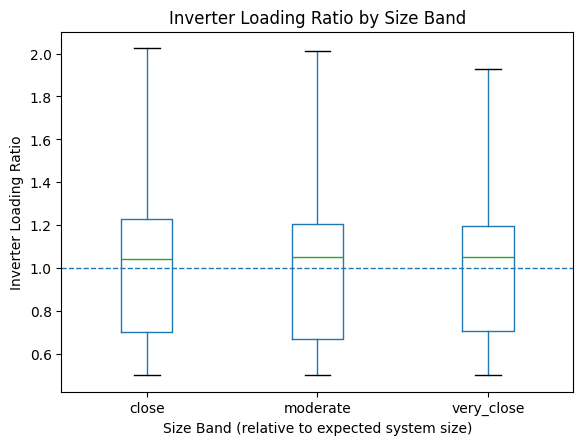

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

df_comparable.boxplot(
    column="inverter_loading_ratio",
    by="size_band",
    grid=False,
    showfliers=False
)

plt.axhline(1.0, linestyle="--", linewidth=1)
plt.xlabel("Size Band (relative to expected system size)")
plt.ylabel("Inverter Loading Ratio")
plt.title("Inverter Loading Ratio by Size Band")
plt.suptitle("")

plt.show()


### Interpretation: Inverter Loading Ratio by Expected-Size Band

The boxplot above provides a visual confirmation of the numerical summaries
reported previously for inverter loading ratio (ILR).

Across all expected-size bands (`very_close`, `close`, `moderate`):

- median ILR values remain tightly centered near 1.0
- interquartile ranges overlap almost completely
- upper and lower tails exhibit similar extent and symmetry
- no size band displays systematic upward or downward displacement

The dashed reference line at ILR = 1.0 highlights that typical inverter loading
behavior is stable regardless of proximity to expected system size.

This visual evidence reinforces the tabular findings: **inverter loading ratio
does not vary meaningfully when systems are conditioned on expected size**.
Any observed variation reflects normal engineering dispersion rather than
band-specific configuration structure.

No further conditioning or stratification is warranted for ILR in this
repository.


## Notebook 2 — Summary and Contribution

This notebook examined whether residential solar systems exhibit meaningful
**within-size structural variation** once expected system size is treated as the
reference frame.

Expected system size—derived upstream—was held fixed in relative terms by
grouping systems according to their deviation from expectation. Configuration
attributes were then evaluated to determine whether systems that are close to,
or moderately deviant from, expectation differ in systematic ways.

### Summary of Findings

Across all configuration classes examined:

**Indicator variables**
- Most binary features (e.g., tracking, ground-mounted systems, ownership model,
  DC optimizers) exhibit stable prevalence across size bands.
- Limited differentiation is observed for new construction and expansion-related
  attributes, indicating modest design flexibility rather than structural
  divergence.

**Categorical variables**
- Technology type, installer identity, utility service territory, and city-level
  geography show highly stable composition across size bands.
- No categorical dimension exhibits meaningful enrichment or depletion as systems
  move toward or away from tight size conformity.

**Numeric variables**
- Inverter loading ratio—the strongest numeric candidate—shows near-identical
  medians, dispersion, and tail behavior across size bands.
- Other numeric configuration fields are either sparsely reported or reflect
  reporting structure rather than substantive design variation.

### Core Structural Result

Once expected system size is accounted for, residential solar systems in
California exhibit **strong structural convergence**.

Configuration choices, component practices, installer identity, and geography do
not explain residual variation near the expected size surface. Deviations from
expected size therefore cannot be attributed to unmodeled configuration mix.

### Analytical Implication

This notebook establishes that **expected system size functions as a sufficient
organizing principle** for residential solar installations.

Within-size residual variation reflects true deviation from a validated market
reference, rather than compensatory configuration behavior.

As a result:
- downstream scaling analysis may treat expected size as a stable reference
  manifold
- abnormality and risk evaluation are not confounded by configuration heterogeneity
- remaining analytical leverage lies in scaling behavior and deviation geometry,
  not within-size structure

This concludes the within-size structural analysis for Repo 3.
